# MCMC uncertainty
*R.A. Collenteur, Eawag, February 2023*

In this notebook it is shown how the MCMC-algorithm can be used to estimate the model parameters and quantify the parameter uncertainties for a Pastas model. Besides Pastas the following Python Packages have to be installed to run this notebook:

- [emcee](https://emcee.readthedocs.io/en/stable/user/faq/)
- [corner](https://corner.readthedocs.io)

In [1]:
import numpy as np
import pandas as pd

import pastas as ps
import emcee
import corner

import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.10.5
NumPy version: 1.22.3
Pandas version: 1.4.3
SciPy version: 1.9.3
Matplotlib version: 3.6.2
Numba version: 0.56.3
LMfit version: 1.0.3
Latexify version: 0.2.0
Pastas version: 1.0.1


## 1. Create a Pastas Model
The first step is to create a Pastas Model object, including the RechargeModel to simulate the effect of precipitation and evaporation on the groundwater heads.

Fit report head                      Fit Statistics
nfev    51                     EVP            89.38
nobs    351                    R2              0.89
noise   True                   RMSE            0.07
tmin    1990-01-01 00:00:00    AIC         -2061.25
tmax    2005-10-14 00:00:00    BIC         -2030.37
freq    D                      Obj             0.47
warmup  3650 days 00:00:00     ___                 
solver  LeastSquares           Interp.           No

Parameters (8 optimized)
                optimal   stderr     initial   vary
rch_A          0.426129   ±6.06%    0.630436   True
rch_n          0.670369   ±2.99%    1.000000   True
rch_a        296.717784  ±13.62%   10.000000   True
rch_srmax     53.419836   ±5.70%  250.000000   True
rch_lp         0.250000    ±nan%    0.250000  False
rch_ks        19.840730  ±11.11%  100.000000   True
rch_gamma      3.961220   ±9.34%    2.000000   True
rch_kv         1.000000    ±nan%    1.000000  False
rch_simax      2.000000    ±nan%    2.

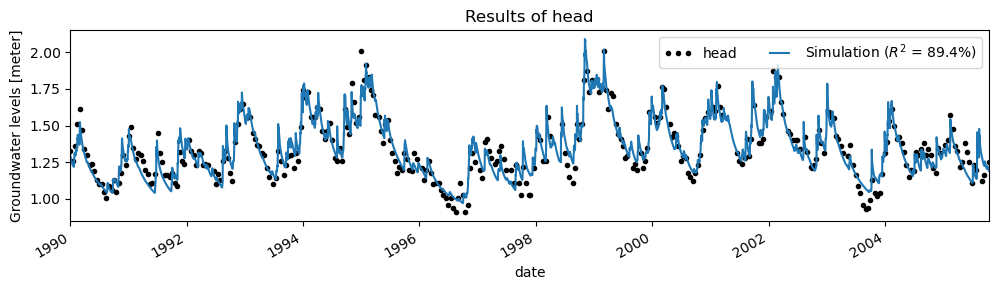

In [2]:
head = pd.read_csv("data/B32C0639001.csv", parse_dates=["date"], index_col="date").squeeze()

# Make this millimeters per day
evap = pd.read_csv("data/evap_260.csv", index_col=0, parse_dates=[0]).squeeze()
rain = pd.read_csv("data/rain_260.csv", index_col=0, parse_dates=[0]).squeeze()

ml = ps.Model(head)

# Select a recharge model
rch = ps.rch.FlexModel()

rm = ps.RechargeModel(rain, evap, recharge=rch, rfunc=ps.Gamma(), name="rch")
ml.add_stressmodel(rm)

ml.solve(noise=True, tmin="1990")

ax = ml.plot(figsize=(10, 3))

## 2. Use the EMCEE Hammer
Apart from the default solver (ps.LeastSquares()), Pastas also contains the option to use the LmFit package to estimate the parameters. This package wraps multiple optimization techniques, one of which is [Emcee](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.Minimizer.emcee). The code bock below shows how to use this method to estimate the parameters of Pastas models.

Emcee takes a number of keyword arguments that determine how the optimization is done. The most important is the `steps` argument, that determines how many steps each of the walkers takes. The argument `nwalkers` can be used to set the number of walkers (default is 100). The `burn` argument determines how many samples from the start of the walkers are removed. The argument `thin` finally determines how many samples are accepted (1 in thin samples).

In [3]:
s = ps.EmceeSolve(
    moves=emcee.moves.DEMove(),
    objective_function=ps.objfunc.GaussianLikelihoodAr1(),
    progress_bar=True,
    parallel=True,
    nwalkers=50,
    #backend=emcee.backends.HDFBackend("test.HDF"),
)

In [4]:
# Use the solver to run MCMC
ml.solve(solver=s, initial=False, noise=False, tmin="1990", steps=5000, tune=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:40<00:00,  7.81it/s]

Fit report head                   Fit Statistics
nfev    nan                    EVP         88.06
nobs    351                    R2           0.88
noise   False                  RMSE         0.07
tmin    1990-01-01 00:00:00    AIC      -1833.10
tmax    2005-10-14 00:00:00    BIC      -1806.08
freq    D                      Obj           nan
warmup  3650 days 00:00:00     ___              
solver  EmceeSolve             Interp.        No

Parameters (7 optimized)
               optimal stderr     initial   vary
rch_A         0.406457  ±nan%    0.426129   True
rch_n         0.680175  ±nan%    0.670369   True
rch_a       288.987510  ±nan%  296.717784   True
rch_srmax    59.185773  ±nan%   53.419836   True
rch_lp        0.250000  ±nan%    0.250000  False
rch_ks       30.683516  ±nan%   19.840730   True
rch_gamma     3.285520  ±nan%    3.961220   True
rch_kv        1.000000  ±nan%    1.000000  False
rch_simax     2.000000  ±nan%    2.000000  False
constant_d    0.795755  ±nan%    0.805807  

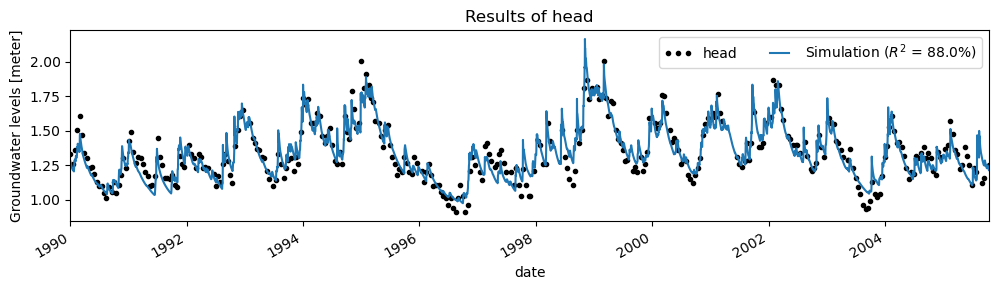

In [5]:
ax = ml.plot(figsize=(10, 3))

## 3. Visualize the results
The results are stored in the `result` object, accessible through `ml.fit.result`. The object `ml.fit.result.flatchain` contains a Pandas DataFrame with $n$ the parameter samples, where $n$ is calculated as follows:

$n = \frac{\left(\text{steps}-\text{burn}\right)\cdot\text{nwalkers}}{\text{thin}} $

## Corner.py
Corner is a simple but great python package that makes creating corner graphs easy. One line of code suffices to create a plot of the parameter distributions and the covariances between the parameters. 

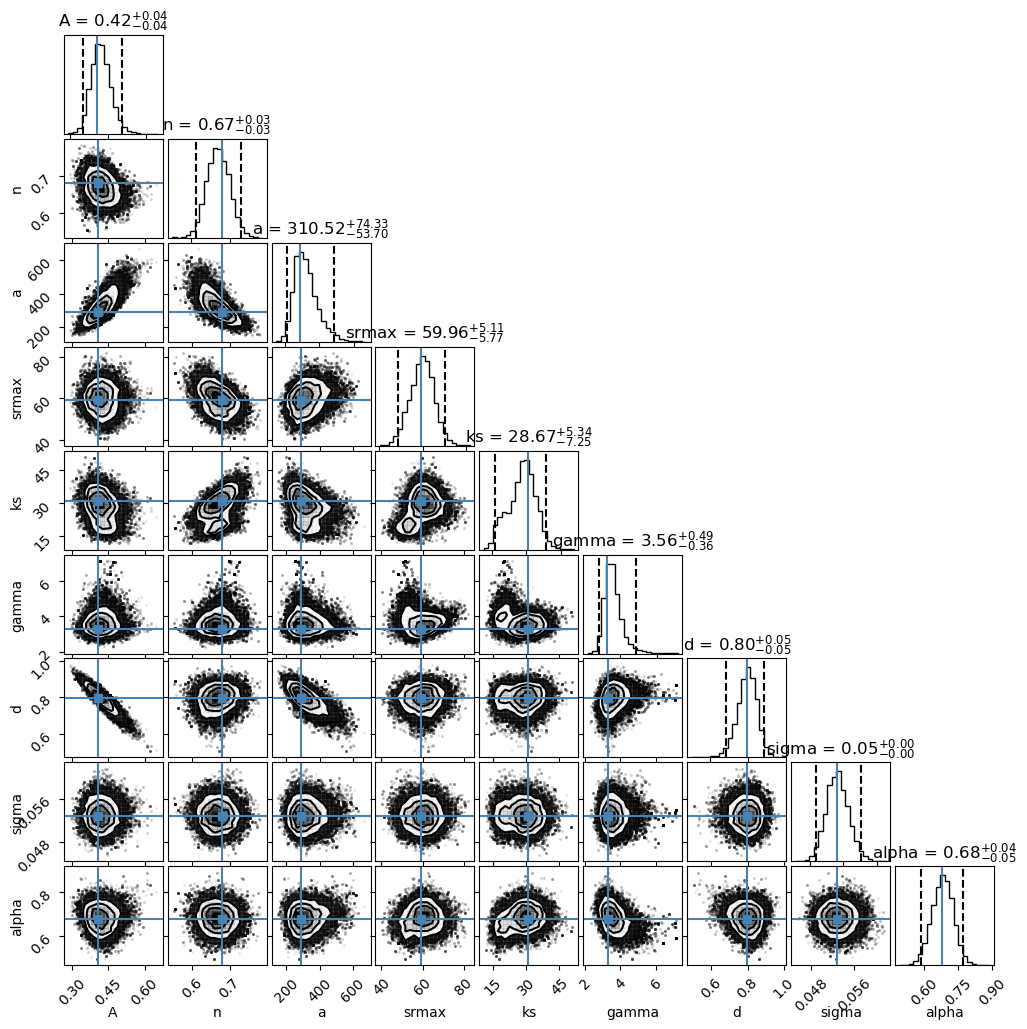

In [6]:
fig = plt.figure(figsize=(10, 10))

labels = list(ml.parameters.index[ml.parameters.vary])
labels = labels + list(ml.fit.parameters.index.values)
labels = [label.split("_")[1] for label in labels]

best = list(ml.parameters[ml.parameters.vary == True].optimal) + \
       list(ml.fit.parameters.optimal)

axes = corner.corner(
    ml.fit.sampler.get_chain(flat=True, discard=3000),
    quantiles=[0.025, 0.975],
    labelpad=0.1,
    show_titles=True,
    label_kwargs=dict(fontsize=10),
    max_n_ticks=3,
    fig=fig,
    labels=labels,
    truths=best,
)

## 4. What happens to the walkers at each step?
The walkers take steps in different directions for each step. It is expected that after a number of steps, the direction of the step becomes random, as a sign that an optimum has been found. This can be checked by looking at the autocorrelation, which should be insignificant after a number of steps (NOT SURE HOW TO INTERPRET THIS YET). However it does not seem the case that the parameters converge to come optimum yet, even for the simple Linear model.

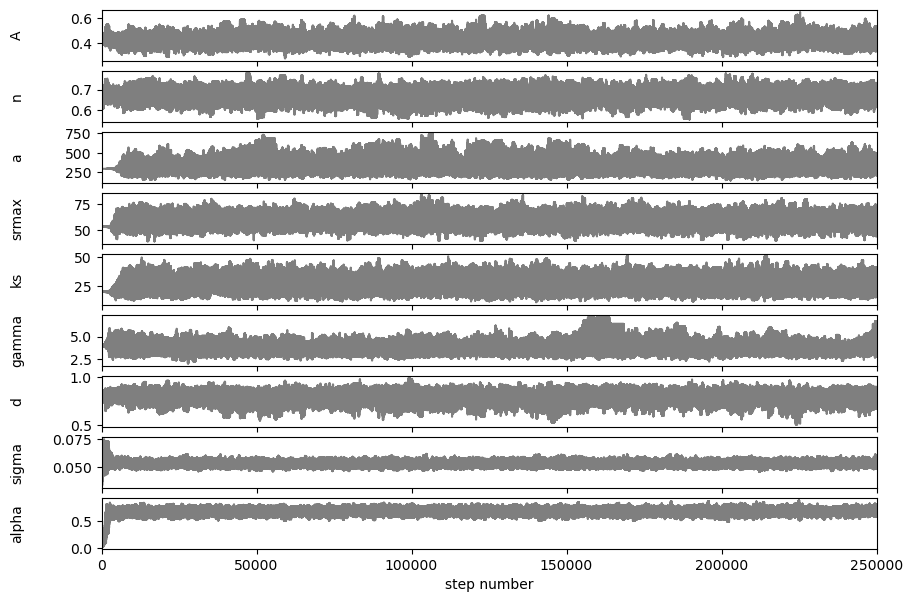

In [7]:
fig, axes = plt.subplots(len(labels), figsize=(10, 7), sharex=True)

samples = ml.fit.sampler.get_chain(flat=True)
for i in range(len(labels)):
    ax = axes[i]
    ax.plot(samples[:, i], "k", alpha=0.5)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

## 5. Plot some simulated time series to display uncertainty?

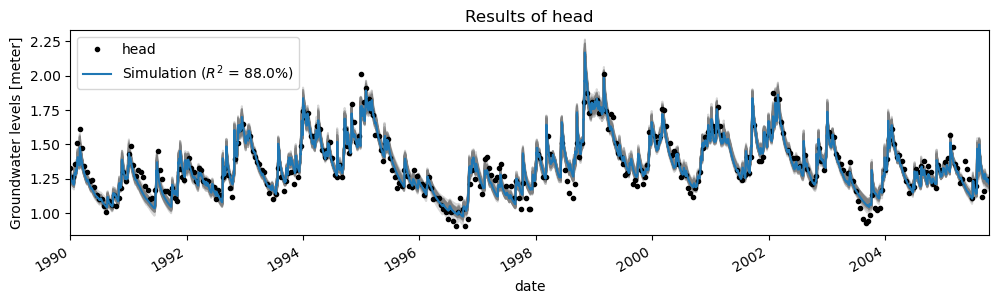

In [8]:
ax = ml.plot(figsize=(10, 3))

chain = ml.fit.sampler.get_chain(flat=True, discard=3000)
inds = np.random.randint(len(chain), size=100)
for ind in inds:
    params = chain[ind]
    p = ml.parameters.optimal.copy().values
    p[ml.parameters.vary == True] = params[:-ml.fit.objective_function.nparam]
    ml.simulate(p, tmin="1990").plot(c="gray", alpha=0.3, zorder=-1, ax=ax)